* Here will use the fashion-MNIST dataset which was released in 2017.
* It contains images of 10 categories of clothing at 28 x 28 pixel resolution.

In [1]:
!pip install d2l --no-deps

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 4.8 MB/s eta 0:00:00


In [2]:
%matplotlib inline
import torch
from d2l import torch as d2l
import time
import torchvision
from torchvision import transforms

d2l.use_svg_display()

## 1.1 Loading the dataset.

* Since the Fashion-MNIST dataset is so useful, all major frameworks provide preprocessed versions of it.
* We can download and read it into memory using built-in framework utilities.

In [3]:
class FashionMNIST(d2l.DataModule):
  """The Fashion-MNIST dataset"""
  def __init__(self,batch_size=64,resize=(28,28)):
    super().__init__()
    self.save_hyperparameters()
    trans = transforms.Compose([
        transforms.Resize(resize),
        transforms.ToTensor()
    ])
    self.train = torchvision.datasets.FashionMNIST(
        root=self.root,train=True,transform=trans,download=True
    )
    self.val = torchvision.datasets.FashionMNIST(
        root=self.root,train=False,transform=trans,download=True
    )

* This datasets consists of images from 10 categories, each represented by 6000 images in the training dataset and by 1000 in the test dataset.
* We will use the test dataset to evaluate the model's performance.

In [4]:
##examining the size of the dataset
data = FashionMNIST(resize=(32,32))
len(data.train),len(data.val)

100%|██████████| 26.4M/26.4M [00:02<00:00, 9.94MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 213kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.94MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 13.4MB/s]


(60000, 10000)

* From above we can see that the training set contains 60,000 images while the test set contains 10,000 images.
* The images are in grayscale and are upscaled to 32x32 pixels in the resolution above.
* However, modern image data has three channels (red,green,blue).
* By convention we store an image as a  `c x h x w` tensor, where $c$ is the number of color channels, $h$ is the height and $w$ is the width.

In [5]:
#examining shape of train data sample
data.train[0][0].shape

torch.Size([1, 32, 32])

In [6]:
@d2l.add_to_class(FashionMNIST)
##giving labels indices
def text_labels(self,indices):
  """Return text labels"""
  labels = [
      't-shirt','trouser','pullover','dress','coat',
      'sandal','shirt','sneaker','bag','ankle boot'
  ]
  return [labels[int(i)] for i in indices]

## 1.2 Reading a MiniBatch

* To make our work easire when reading from training and test set,we use the built-in data iterator rather than creating one from scratch.
* At each iteration, a data iterator reads a minibatch of data with **batch_size**.
* We also randomly shuffle the examples for the training data iterator.

In [7]:
@d2l.add_to_class(FashionMNIST)
def get_dataloader(self,train):
  data = self.train if train else self.val
  return torch.utils.data.DataLoader(data,self.batch_size,shuffle=train,num_workers=self.num_workers)


In [8]:
##loading a minibatch of images by
##invoking the train_dataloader method
X,y =next(iter(data.train_dataloader()))
print(X.shape,X.dtype,y.shape,y.shape)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


torch.Size([64, 1, 32, 32]) torch.float32 torch.Size([64]) torch.Size([64])


In [9]:
##looking at the time it takes to read the images.
tic = time.time()
for X,y in data.train_dataloader():
  continue
f'{time.time() - tic:.2f} sec'

'10.22 sec'

## 1.3 Visualization.

* Now let's visualize the images.
* For convenience we use the **show_images**

In [10]:
def show_images(imgs,num_rows,num_cols,titles=None,scale=1.5):
  """Plot a list of images"""
  raise NotImplementedError

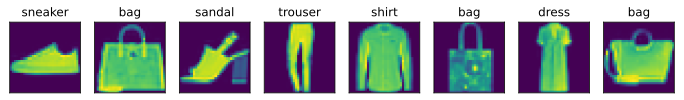

In [11]:
@d2l.add_to_class(FashionMNIST)
def visualize(self,batch,nrows=1,ncols=8,labels=[]):
  X,y = batch
  if not labels:
    labels = self.text_labels(y)
  d2l.show_images(X.squeeze(1),nrows,ncols,titles=labels)
batch = next(iter(data.train_dataloader()))
data.visualize(batch)

## 2.1 The Base Classification Model

## 2.1.1 The Classifier class

* Here the define the *Classifier* class.
* In the *validation_step* we reort both the loss value and the classificaton accuracy on a validation batch.
* We draw an update for every *num_val_batches* batches.

In [12]:
class Classifier(d2l.Module):
  """The base class of classification models."""
  def validation_step(self,batch):
    y_hat = self(*batch[:-1])
    self.plot('loss',self.loss(y_hat,batch[-1]),train=False)
    self.plot('acc',self.accuracy(y_hat,batch[-1]),train=False)


* Here we also use the stochastic gradient descent optimizer, operating on minibatches.

In [13]:
@d2l.add_to_class(d2l.Module)
def configure_optimizer(self):
  return torch.optim.SGD(self.parameters(),lr=self.lr)

## 2.1.2 Accuracy

* Given the probability distribution *y_hat*, we typically choose the class with the highest predicted probability whenever we must output a hard prediction.
* When the predictions are consistent with the label class *y*, they are correct.
* The classification accuracy is the fraction of all predictions that are correct.

* Accuracy is computed as follows.
* First, if *y_hat* is a matrix, we assume that the second dimension stores prediction scores for each class.
* We use *argmax* to obtain the predicted class by the index for the largest entry in each row.
* Then we compute the predicted class with the ground truth *y* elementwise.
* Since the equality operator == is senstive to data types, we convert *y_hat*'s datatype to match that of *y*.
* The result is a tensor containing entries of 0 (false) and 1 (true).
* Taking the sum yields the number of correct predictions.

In [28]:
@d2l.add_to_class(Classifier)
def accuracy(self,y_hat,y):
  """Compute the number of correct predictions."""
  y_hat = y_hat.reshape((-1,y_hat.shape[-1]))
  preds = y_hat.argmax(axis=1).type(y.dtype)
  compare = (preds == y).type(torch.float32)
  return compare.mean()

## 3.1 Softmax Regression from Scratch

# 3.1.1 The Softmax

* Let's start by mapping scalars to probabilities.
* Given a matrix $X$ we can sum over all elements or only over elements in the same axis.
* The axis varaible lets us compute row and column sums.

In [15]:
X = torch.tensor(
    [
        [1.0,2.0,3.0],
        [4.0,5.0,6.0]
    ]
)
X.sum(0,keepdim=True),X.sum(1,keepdim=True)

(tensor([[5., 7., 9.]]),
 tensor([[ 6.],
         [15.]]))

* Computing the softmax requires three steps:
  1. Exponentiation of each item.
  2. A sum over each row to compute the normalization constant for each example.
  3. The division of each row by its normalization consant, ensuring the results sums to 1.

* The logarithm of the denominator is called the $(log) partition function.$

In [16]:
def softmax(X):
  X_exp = torch.exp(X)
  partition = X_exp.sum(1,keepdim=True)
  return X_exp / partition

* For any input X,we turn each element into a nonnegative number.
* Each row sums up to 1, as is required for a probability.
* The above code is for illustrative purpose and is not recommended when computing softmax.
* Deep learning frameworks have built-in softmax functions which do the heavy work.

In [17]:
X = torch.rand((2,5))
X_prob = softmax(X)
X_prob,X_prob.sum(1)

(tensor([[0.2262, 0.2240, 0.1877, 0.1172, 0.2450],
         [0.2754, 0.2977, 0.1506, 0.1431, 0.1331]]),
 tensor([1., 1.]))

## 4 The Model

* Let's implement our softmax regression model.
* As in linear regression, each instance will be represented by a fixed-length vector.
* Since the raw data consists of 28x28 pixel images, we flatten each image, treating them as vectors of length 784.
* In softmax regression, the number of number of ouputs from our network should be equal to number of classes.
* Since our dataset has 10 classes,our network has an output dimension of 10.
* Our weights constitute a 784x10 matrix plus a 1x10 row vector for the biases.

In [18]:
class SoftmaxModel(d2l.Classifier):
  def __init__(self,num_inputs,num_outputs,lr,sigma=0.01):
    super().__init__()
    self.save_hyperparameters()
    self.W = torch.normal(0,sigma,size=(num_inputs,num_outputs),requires_grad=True)
    self.b  = torch.zeros(num_outputs,requires_grad=True)

  def parameters(self):
    return [self.W,self.b]

* Below we define code that shows how the network maps each input to outpt.

In [26]:
@d2l.add_to_class(SoftmaxModel)
def forward(self,x):
  x = x.reshape((-1,self.W.shape[0]))
  return softmax(torch.matmul(x,self.W) + self.b)

## 5 The Cross-Entropy Loss

* Recall that cross-entropy takes the negative log-likelihood of the predicted probabiity assigned to the true label.
* For efficiency we avoid Python for-loops and use indexing instead.
* In particular, the one-hot encoding in $y$ allows us to select the matching term in $\hat{y}$.
* To see this in action we create sample data $y_hat$ with 2 examples of the predicted probabilities over 3 classes and their corresponding labels $y$.
* The correct labels are 0 and 2 respectively i.e the first and third class.

In [22]:
y =torch.tensor([0,2])
y_hat = torch.tensor([[0.1,0.3,0.6],[0.3,0.2,0.5]])
y_hat[[0,1],y]

tensor([0.1000, 0.5000])

* Let's now implement the cross-entropy loss function by averaging over the logarithms of the selected probabilities.

In [23]:
def cross_entropy(y_hat,y):
  return -torch.log(y_hat[list(range(len(y_hat))),y]).mean()
cross_entropy(y_hat,y)

tensor(1.4979)

In [24]:
@d2l.add_to_class(SoftmaxModel)
def loss(self,y_hat,y):
  return cross_entropy(y_hat,y)

## 6 Training

* Here we reuse the $fit$ method to train the model with 10 epochs.
* Note that the number of epochs `max_epochs`,the minibatch size `batch_size` and learning rate `lr` are adjustable hyperparameters.
* This means that while these values are not learned during our primary training loop,they still influence the performance of our model, both vis-a-vis training and generalization performance.

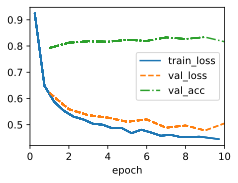

In [33]:
data = d2l.FashionMNIST(batch_size=256)
model = SoftmaxModel(num_inputs=784,num_outputs=10,lr=0.1)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model,data)

## 7 Prediction

In [30]:
X,y = next(iter(data.val_dataloader()))
preds = model(X).argmax(axis=1)
preds.shape

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


torch.Size([256])

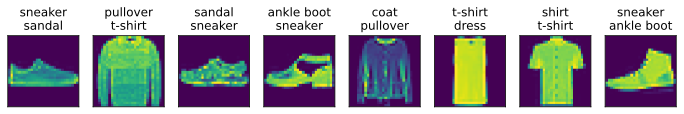

In [31]:
##comparing wrongly predicted images with their actual
##labels
wrong = preds.type(y.dtype) != y
X,y,preds = X[wrong],y[wrong],preds[wrong]
labels = [a+'\n'+b for a,b in zip(
    data.text_labels(y),data.text_labels(preds)
)]
data.visualize([X,y],labels=labels)

## 8 Concise Implementation of Softmax Regression

* Here we implement softmax regression using pytorch.

### 8.1 Defining the model

* We use a `Flatten` layer to convert the fourth-order tensor X to a second order by keeping the dimensionality along the first axis unchanged.

In [50]:
import torch
from torch import nn
from torch.nn import functional as F

In [51]:
class SoftMaxRegression(d2l.Classifier):
  def __init__(self,num_outputs,lr):
    super().__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(
        nn.Flatten(),
        nn.LazyLinear(num_outputs)
    )
  def forward(self,x):
    return self.net(X)

## 8.2 Softmax

* Directly computing softmax followed by cross-entropy loss is mathematically correct but can cause numerical instability due to overflow i.e large exponentiation or underflow i.e very small exponentiation.
* This happens because the exponentiation function can exceed the representable range of floating-point numbers i.e $10^{-38} to 10^{38}$.
* To improve stability, the maximum logit value is  subtracted from all logits before applying softmax.
* The equation of doing this is shown below:
  $y_j = \frac{\exp(o_j)}{\sum_k \exp(o_k)} = \frac{\exp(o_j - \bar{o}) \exp(\bar{o})}{\sum_k \exp(o_k - \bar{o}) \exp(\bar{o})} = \frac{\exp(o_j - \bar{o})}{\sum_k \exp(o_k - \bar{o})}$
* This keeps all exponent values non-positive,preventing overflow and limiting the denominator to a safe range.
* However,underflow can still lead to zeros, which become problematic when taking logarithms during backpropagation.

* The key solution is the **combine softmax and cross-entropy** into a single computation.
* By computing the log-softmax directly, the exponentials and logarithms cancel appropriately,avoiding both overflow and underflow.
* Here's the equation:
  $\log \hat{y}_j = \log \frac{\exp(o_j - \bar{o})}{\sum_k \exp(o_k - \bar{o})} = (o_j - \bar{o}) - \log \sum_k \exp(o_k - \bar{o})$
* This approach, often implemented using the **LogSumExp trick**,since it is numerically stable and is why modern frameworks compute cross-entropy directly from logits rather than from softmax probabilities.

In [53]:
@d2l.add_to_class(d2l.Classifier)
def loss(self,y_hat,y,averaged=True):
  y_hat = y_hat.reshape((-1,y_hat.shape[-1]))
  y = y.reshape((-1,))
  return F.cross_entropy(
      y_hat,y,reduction='mean' if averaged else 'none'
  )

## 8.3 Training

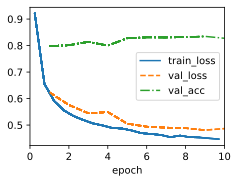

In [54]:
data =d2l.FashionMNIST(batch_size=256)
model = d2l.SoftmaxRegression(num_outputs=10,lr=0.1)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model,data)